<a href="https://colab.research.google.com/github/flaghunter21/DSCI-619-Deep-Learning/blob/main/DSCI_619_Final_Project_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSCI 619 Final Project Part 2
## Cameron Lauf

In this project, we will be using the `Sentiment140` dataset which contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment.

https://www.kaggle.com/datasets/kazanova/sentiment140

The goal of this project is to use Recurrent Neural Networks (RNN) to perform sentiment analysis on the data.

## Load the data

In [43]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [44]:
tweets = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1")
tweets.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [45]:
data_columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
tweets = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", names = data_columns)
tweets.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [46]:
print(len(tweets))

1600000


## Data Cleaning and Preprocessing

For this analysis, only the `target` and `text` column will be relevant.

In [47]:
tweets = tweets[['target','text']]
tweets['target'] = tweets['target'].replace(4, 1)
tweets.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


We also see there are 800,000 tweets of each positive and negative sentiment.

In [48]:
print(tweets['target'].value_counts())

0    800000
1    800000
Name: target, dtype: int64


To preprocess the text data, the following steps will need to be taken:
* Lower case text
* Replace URLs
* Replace emojis
* Replace usernames
* Remove Non-Alphabet characters
* Replace 3 or more consecutive letters with 2.
* Remove words with length less than or equal to 2.
* Remove stop words
* Lemmatization

In [49]:
text, target = list(tweets['text']), list(tweets['target'])

In [50]:
# Dictionary of emojis
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# Stop word list
stop_words = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [51]:
# Preprocessing function
def preprocess(text_data):
  processed_text = []
  lemmatizer = WordNetLemmatizer()

  # Regex patterns
  urls = r'((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)'
  users = '@[^\s]+'
  alpha = '[^a-zA-Z0-9]'
  seq = r'(.)\1\1+'
  seq_replace = r'\1\1'

  for tweet in text_data:
    # Lower casing
    tweet = tweet.lower()

    # Replace URLs
    tweet = re.sub(urls,' URL',tweet)

    # Replace emojis
    for emoji in emojis.keys():
      tweet = tweet.replace(emoji, 'EMOJI' + emojis[emoji])

    # Replace usernames
    tweet = re.sub(users,' USER', tweet)

    # Replace non alphabetic
    tweet = re.sub(alpha, ' ', tweet)

    # Replace consecutive letters (>=3)
    tweet = re.sub(seq, seq_replace, tweet)

    # Stop words and lemmatization
    tweet_words = ''
    for word in tweet.split():
      if len(word) > 1:
        word = lemmatizer.lemmatize(word)
        tweet_words += (word + ' ')

    # Append text to list
    processed_text.append(tweet_words)
  
  return processed_text

In [52]:
processed_text = preprocess(text)

Let's look at a few examples of the now processed text.

In [53]:
processed_text[:3]

['USER URL aww that bummer you shoulda got david carr of third day to do it EMOJIwink ',
 'is upset that he can update his facebook by texting it and might cry a result school today also blah ',
 'USER dived many time for the ball managed to save 50 the rest go out of bound ']

In [54]:
tweets_df = pd.DataFrame({'target':target,
                          'text':processed_text})
tweets_df.head()

,target,text
0,0,USER URL aww that bummer you shoulda got david...
1,0,is upset that he can update his facebook by te...
2,0,USER dived many time for the ball managed to s...
3,0,my whole body feel itchy and like it on fire
4,0,USER no it not behaving at all mad why am here...


## Train Test Split and Vectorization

We now convert the text to numerical values using text vectorization.

In [55]:
X = tweets_df['text'].values
y = tweets_df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [56]:
print(f'X_train Size: {X_train.shape}')
print(f'y_train Size: {X_test.shape}')
print('--------------------')
print(f'X_test Size: {y_train.shape}')
print(f'y_test Size: {y_test.shape}')

X_train Size: (1280000,)
y_train Size: (320000,)
--------------------
X_test Size: (1280000,)
y_test Size: (320000,)


In [57]:
# Specify the vocab size
VOCAB_SIZE = 1000
# Perform textvectorization
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Fits the state of the preprocessing layer to the dataset.
encoder.adapt(X_train)

In [58]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'user', 'to', 'the', 'it', 'my', 'and', 'you', 'is',
       'in', 'for', 'of', 'on', 'that', 'me', 'so', 'have', 'but', 'just'],
      dtype='<U13')

## Baseline RNN Model with GRU

In [119]:
model = tf.keras.Sequential([
    # Convert review text to indices
    encoder, 
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU((128)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    # Binary classifier
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [120]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [121]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_21 (Embedding)    (None, None, 64)          64000     
                                                                 
 gru_21 (GRU)                (None, None, 128)         74496     
                                                                 
 gru_22 (GRU)                (None, 128)               99072     
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                     

In [122]:
%%time
history = model.fit(x=X_train,y=y_train,batch_size = 80,epochs=5,
          validation_data=(X_test,y_test), verbose = 1
          )

Epoch 1/5
16000/16000 [==============================] - 394s 24ms/step - loss: 0.4786 - accuracy: 0.7564 - val_loss: 0.4654 - val_accuracy: 0.7711
Epoch 2/5
16000/16000 [==============================] - 385s 24ms/step - loss: 0.4537 - accuracy: 0.7718 - val_loss: 0.4480 - val_accuracy: 0.7775
Epoch 3/5
16000/16000 [==============================] - 386s 24ms/step - loss: 0.4444 - accuracy: 0.7778 - val_loss: 0.4428 - val_accuracy: 0.7819
Epoch 4/5
16000/16000 [==============================] - 386s 24ms/step - loss: 0.4383 - accuracy: 0.7815 - val_loss: 0.4369 - val_accuracy: 0.7817
Epoch 5/5
16000/16000 [==============================] - 422s 26ms/step - loss: 0.4335 - accuracy: 0.7843 - val_loss: 0.4337 - val_accuracy: 0.7829
CPU times: user 51min 2s, sys: 2min 51s, total: 53min 53s
Wall time: 33min 28s


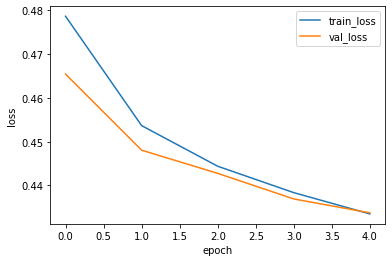

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
sns.lineplot(x='epoch', y ='loss', data =train_history)
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
plt.legend(labels=['train_loss', 'val_loss'])

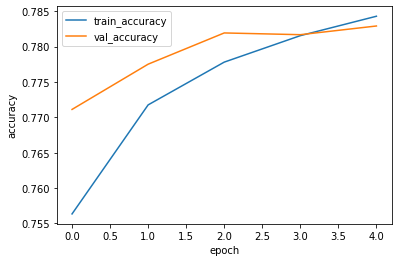

In [124]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [125]:
from sklearn.metrics import confusion_matrix
y_pred = (model.predict(X_test)> 0.5).astype(int)
confusion_matrix(y_test, y_pred)

array([[139782,  20218],
       [ 49255, 110745]])

In [126]:
from sklearn.metrics import classification_report
label_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    negative       0.74      0.87      0.80    160000
    positive       0.85      0.69      0.76    160000

    accuracy                           0.78    320000
   macro avg       0.79      0.78      0.78    320000
weighted avg       0.79      0.78      0.78    320000



The baseline model acheived an accuracy of 78%. We will now try using LSTM layer.

## RNN Model using LSTM

In [128]:
model = tf.keras.Sequential([
    # Convert review text to indices
    encoder, 
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    
    #tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    # Binary classifier
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [129]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [130]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_23 (Embedding)    (None, None, 64)          64000     
                                                                 
 bidirectional_10 (Bidirecti  (None, 256)              197632    
 onal)                                                           
                                                                 
 dense_38 (Dense)            (None, 64)                16448     
                                                                 
 dense_39 (Dense)            (None, 1)                 65        
                                                                 
Total params: 278,145
Trainable params: 278,145
Non-t

In [131]:
%%time
history = model.fit(x=X_train,y=y_train,batch_size = 80,epochs=5,
          validation_data=(X_test,y_test), verbose = 1
          )

Epoch 1/5
16000/16000 [==============================] - 411s 25ms/step - loss: 0.4756 - accuracy: 0.7568 - val_loss: 0.4599 - val_accuracy: 0.7672
Epoch 2/5
16000/16000 [==============================] - 404s 25ms/step - loss: 0.4526 - accuracy: 0.7721 - val_loss: 0.4491 - val_accuracy: 0.7666
Epoch 3/5
16000/16000 [==============================] - 404s 25ms/step - loss: 0.4424 - accuracy: 0.7789 - val_loss: 0.4403 - val_accuracy: 0.7768
Epoch 4/5
16000/16000 [==============================] - 403s 25ms/step - loss: 0.4356 - accuracy: 0.7829 - val_loss: 0.4358 - val_accuracy: 0.7811
Epoch 5/5
16000/16000 [==============================] - 398s 25ms/step - loss: 0.4310 - accuracy: 0.7855 - val_loss: 0.4338 - val_accuracy: 0.7881
CPU times: user 52min 53s, sys: 3min 8s, total: 56min 1s
Wall time: 33min 40s


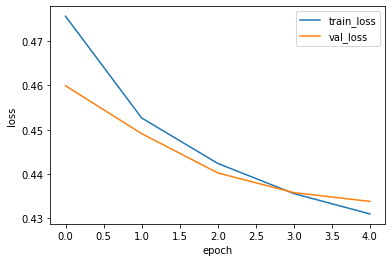

In [132]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
sns.lineplot(x='epoch', y ='loss', data =train_history)
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
plt.legend(labels=['train_loss', 'val_loss'])

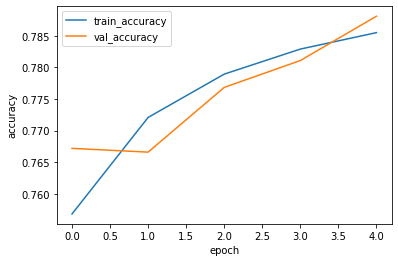

In [133]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [134]:
y_pred = (model.predict(X_test)> 0.5).astype(int)
confusion_matrix(y_test, y_pred)

array([[137222,  22778],
       [ 45028, 114972]])

In [135]:
label_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    negative       0.75      0.86      0.80    160000
    positive       0.83      0.72      0.77    160000

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



This model acheived about the same accuracy as the baseline at 79%.

## RNN Model Using GRU and LSTM

In [136]:
model = tf.keras.Sequential([
    # Convert review text to indices
    encoder, 
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    # Binary classifier
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [137]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [138]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_24 (Embedding)    (None, None, 64)          64000     
                                                                 
 gru_23 (GRU)                (None, None, 128)         74496     
                                                                 
 bidirectional_11 (Bidirecti  (None, 256)              263168    
 onal)                                                           
                                                                 
 dense_40 (Dense)            (None, 64)                16448     
                                                                 
 dense_41 (Dense)            (None, 1)               

In [139]:
%%time
history = model.fit(x=X_train,y=y_train,batch_size = 80,epochs=5,
          validation_data=(X_test,y_test), verbose = 1
          )

Epoch 1/5
16000/16000 [==============================] - 521s 32ms/step - loss: 0.4749 - accuracy: 0.7573 - val_loss: 0.4586 - val_accuracy: 0.7610
Epoch 2/5
16000/16000 [==============================] - 504s 32ms/step - loss: 0.4495 - accuracy: 0.7745 - val_loss: 0.4472 - val_accuracy: 0.7700
Epoch 3/5
16000/16000 [==============================] - 505s 32ms/step - loss: 0.4398 - accuracy: 0.7809 - val_loss: 0.4399 - val_accuracy: 0.7701
Epoch 4/5
16000/16000 [==============================] - 505s 32ms/step - loss: 0.4339 - accuracy: 0.7842 - val_loss: 0.4340 - val_accuracy: 0.7829
Epoch 5/5
16000/16000 [==============================] - 505s 32ms/step - loss: 0.4293 - accuracy: 0.7872 - val_loss: 0.4305 - val_accuracy: 0.7887
CPU times: user 1h 1min 59s, sys: 3min 47s, total: 1h 5min 46s
Wall time: 42min 21s


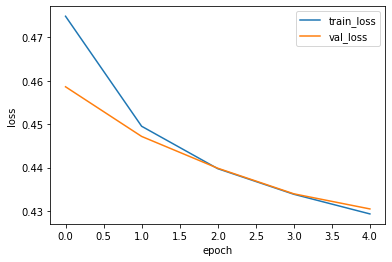

In [140]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
sns.lineplot(x='epoch', y ='loss', data =train_history)
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
plt.legend(labels=['train_loss', 'val_loss'])

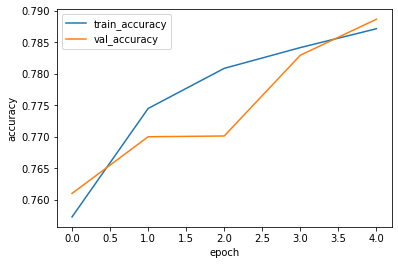

In [141]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [142]:
y_pred = (model.predict(X_test)> 0.5).astype(int)
confusion_matrix(y_test, y_pred)

array([[138224,  21776],
       [ 45849, 114151]])

In [143]:
label_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    negative       0.75      0.86      0.80    160000
    positive       0.84      0.71      0.77    160000

    accuracy                           0.79    320000
   macro avg       0.80      0.79      0.79    320000
weighted avg       0.80      0.79      0.79    320000



It seems that none of the models are overfitting and the accuracy is consistently around 78-79%.